In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import ipywidgets as widgets
from scipy.io import loadmat
from IPython.display import display, Markdown, clear_output
from ipywidgets import interact, interactive, interactive_output
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import ipywidgets as widgets
import scipy
import matplotlib
import sklearn
from IPython.display import clear_output, display
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample

from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.stats import chi2_contingency, ttest_ind,ttest_1samp, spearmanr

from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

from tempfile import TemporaryFile
from random import randint
#import networkx as nx
#from pyvis.network import Network

import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

np.random.seed(42)


In [2]:
# define config
class structtype():
    pass

config = structtype()
config.deploy_flag = 0
config.figure_dir = "figures/python/"
config.session_4c56_boundaries = [1070, 1190,990,750,550]
def set_axis_defaults():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# define cat variable labels
labels = {'cl': ["2/3", "4a/b", "4cα", "4cβ", "5", "6", "WM"], 
         'sc': ["Com.", "Sim."],
         'ct': ["AS", "FS", "RM", "RL"]}

In [3]:
def make_cont_mtx(cat_row, cat_col, cont, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    cont_mtx = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            cont_mtx[idxr, idxc] = np.nanmean(cont[np.logical_and(cat_row == row,cat_col == col)]);
    return cont_mtx;

def make_prop_mtx(cat_row, cat_col, numer_var, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    prop_numer = np.zeros((cat_rows.size, cat_cols.size))
    prop_denom = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            subset = np.logical_and(cat_row == row,cat_col == col)
            rev_subset = np.logical_and(cat_row == col, cat_col == row)
            either_subset = np.logical_or(subset, rev_subset)
            prop_numer[idxr, idxc] = np.nansum(numer_var[subset])
            prop_denom[idxr, idxc] = np.size(numer_var[subset])
            
    prop_mtx = np.divide(prop_numer, prop_denom)
    return prop_mtx, prop_numer, prop_denom

def plot_joint(data, x, y, fig_path, estimator=np.median, text_xpos=.6, text_ypos=.1, marg_color='#b61616', xlim=None, ylim=None, reg_outlier_y=False):
    r, p = spearmanr(data[x],data[y])
    
    reg_x = data[x].to_numpy().reshape(-1, 1)
    reg_y = data[y].to_numpy().reshape(-1, 1)
    if reg_outlier_y:
        y_include = np.logical_and.reduce((data[y]<=(1.5*scipy.stats.iqr(data[y]) + np.quantile(data[y], .75)),
                             data[y]>=(-1.5*scipy.stats.iqr(data[y]) + np.quantile(data[y], .25))))
        reg_x = reg_x[y_include]
        reg_y = reg_y[y_include]
        
    regr = linear_model.LinearRegression()
    regr.fit(reg_x, reg_y)
    y_pred = regr.predict(reg_x)

    b_0 = regr.intercept_
    b_1 = regr.coef_[0][0]

    g = sns.JointGrid(data=data, x=x, y=y, size=4)
    g.plot_joint(sns.regplot,data=data, order=1,x_bins=10,x_estimator=estimator,fit_reg = False, color='k', truncate=True)
    
    xlim = g.ax_joint.get_xlim()
    ylim = g.ax_joint.get_ylim()
    sns.kdeplot(y=y, data=data, ax=g.ax_marg_y, fill=False, color=marg_color,  linewidth=2)
    sns.kdeplot(x=x, data=data,  ax=g.ax_marg_x, fill=False, color=marg_color, linewidth=2)
    
    g.ax_joint.get_shared_y_axes().remove(g.ax_joint)
    g.ax_joint.get_shared_x_axes().remove(g.ax_joint)
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    
    #g.ax_marg_x.set_xticks([g.ax_marg_x.get_xticks()[0],g.ax_marg_x.get_xticks()[-1]])
    #g.ax_marg_x.set_xticklabels([str(xlim[0]), str(xlim[1])])
    
    plt.sca(g.ax_joint)
    
    plt.plot(reg_x, y_pred, color='k', linewidth=2)

    plt_text = '$n =$' + str(int(data.shape[0])) + ',\n$r_s =$ ' + str(round(r, 2)) + ',\n' 
    plt_text = plt_text + '$p_s =$ ' + "{:.2e}".format(p) + ',\n$b_1 =$ ' + "{:.2e}".format(b_1)
    plt.gca().text(text_xpos,text_ypos,plt_text,transform = plt.gca().transAxes)
    set_axis_defaults()
    if xlim:
        plt.gca().set_xlim(xlim)
    if ylim:
        plt.gca().set_ylim(ylim)
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()

def run_linear_regression(data, y, x1, x2):
    print('\033[1m' + 'Linear Regression: ' + y + " = " + 'b_0 + ' + 'b_1*' + x1 + ' b_2*' + x2 + ' + interaction \033[0m')
    x1_var = data[x1].to_numpy()
    x2_var = data[x2].to_numpy()
    x1_x_x2 = x1_var * x2_var
    
    X = np.stack((x1_var,x2_var, x1_x_x2), axis=1)
    X = sm.add_constant(X)
    
    y = data[y].to_numpy()
    
    est = sm.OLS(y, X)
    est = est.fit()
    print("regression p-values:")
    print(est.pvalues)
    print(est.summary())

def construct_matched_data(data, match_by):
    data = data.copy(deep=True)
    match_idx = np.argsort(data[match_by].to_numpy())
    nobs = match_idx.shape[0]
    matched_data = data.head(int(np.floor(nobs/2)))
    for column_name, column_data in data.iteritems():
        even_data = (column_data.to_numpy()[match_idx])[0:nobs-1:2]
        odd_data = (column_data.to_numpy()[match_idx])[1:nobs:2]
        matched_data[column_name] = even_data-odd_data
        
    for column_name, column_data in data.iteritems():
        matched_data[column_name + " diff."] = matched_data[column_name]
    
    return matched_data

In [4]:
# analysis functions
def von_mises(x, a_0, a_1, a_2, a_3):
    return a_0 + a_1*np.exp(a_2*(np.cos(2*x-2*a_3)-1))

def fit_von_mises(ydata):
    xdata = np.linspace(0, 2*np.pi, 36)
    popt, pcov = scipy.optimize.curve_fit(von_mises, xdata, ydata, maxfev=100000)
    return np.rad2deg(xdata), von_mises(xdata,*popt)

In [5]:
flag = loadmat('output/config.mat')

if not flag['group_sessions'][0][0]:
    flag['group_labels'] = [""]
elif flag['group_by_animals'][0][0]:
    flag['group_labels'] = ["monkey 1", "monkey 2"]
else:
    flag['group_labels'] = ["ses 1", "ses 2", "ses 3", "ses 4", "ses 5"]

for group_idx in range(int(flag['group_cnt'])):
    if flag['group_sessions'][0][0]:
        config.figure_dir = "figures/python/" + flag['group_labels'][group_idx]+ "/"
    
    ccg_data = loadmat('output/25-Aug-2021/ccg_attributes_large_' + flag['group_labels'][group_idx] + '.mat', chars_as_strings=True)
    ccg_data = ccg_data['ccg_data'][0][0]

    # paper figures/focus on siegle framing/new exclusion criteria
    ccg_all = ccg_data['ccg'][0][0].copy()
    ccg_curr = ccg_all.copy()
    ccg_curr_half = ccg_all.copy()

    noise_std = ccg_all['noise_std2']
    noise_mean = ccg_all['noise_mean2']
    subset = np.logical_and.reduce((noise_std>0, ccg_all['peaks']>7*noise_std + noise_mean, ccg_all['peak_lag']>=-10, ccg_all['peak_lag']<=10));

    test = np.transpose((np.arange(subset.shape[0]) % 2) == 0)   
    subset_half = np.logical_and(np.squeeze(subset), np.transpose(np.mod(np.arange(subset.shape[0]), 2) == 0))
    
    # correct depths for both clusters and pairs across sessions
    cluster_session = np.squeeze(np.array(ccg_data[0][0]['cluster'][0][0]['Cluster_session'][0][0], dtype='int32'))-1
    ses_boundaries = (np.array(config.session_4c56_boundaries))[cluster_session]
    ccg_data[0][0]['cluster'][0][0]['Cluster_celldepth'][0][0] = np.squeeze(np.array(ccg_data[0][0]['cluster'][0][0]['Cluster_celldepth'][0][0]))-ses_boundaries

    pair_session = np.squeeze(np.array(ccg_data[0][0]['session'][0][0], dtype='int32'))-1
    ses_boundaries = (np.array(config.session_4c56_boundaries))[pair_session]
    ccg_data[0][0]['pre_depth'][0][0] = np.squeeze(np.array(ccg_data[0][0]['pre_depth'][0][0]))-ses_boundaries
    ccg_data[0][0]['post_depth'][0][0] =  np.squeeze(np.array(ccg_data[0][0]['post_depth'][0][0]))-ses_boundaries
    
    # subset based on signficance
    ccg_fields = ccg_data['ccg'][0][0].dtype.names
    for field in ccg_fields:
        if field != 'config' and field != 'cluster':
            ccg_curr[field] = ccg_all[field][np.squeeze(subset)]
            ccg_curr_half[field] = ccg_all[field][np.squeeze(subset_half)]

    ids = [389, 401, 522, 542]
    cols = ['#FF0F80','#E9190F','#008BF8','#F5B700']


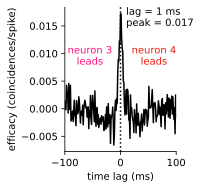

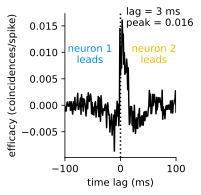

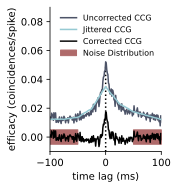

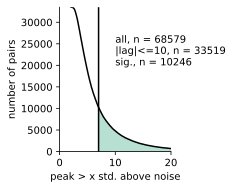

In [6]:
def plot_figure1(ccg_curr,ccg_curr_half, ccg_all, ids):
    ids = np.array(ids) + 1 # because 1 indexing for examples
    # plot 1 good example ccg (full range)
    ex_id = np.nonzero(np.squeeze(np.logical_and(ccg_curr['pre_id']==ids[0], ccg_curr['post_id']==ids[1])))
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    ex_ccg_jitter = ccg_curr['ccg_jitter'][ex_id]
    ex_ccg_norm = ccg_curr['ccg_norm'][ex_id]

    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_norm), color='#4d5468')
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_jitter), color='#96cad3')
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_control), color='k',)
    plt.fill_between(x=[-100, -50],y1=-0.005, y2=0.005, color="#af6a6a")
    plt.legend(["Uncorrected CCG", "Jittered CCG","Corrected CCG", "Noise Distribution"], frameon=False, fontsize=8)
    plt.vlines(0,-0.01,0.05, color='k', linestyle='dotted')

    plt.fill_between(x=[50, 100],y1=-0.005, y2=0.005, color="#af6a6a")

    plt.xlim((-100, 100))
    plt.ylim(-0.01, 0.09)
    plt.xlabel('time lag (ms)')
    plt.ylabel('efficacy (coincidences/spike)')
    rounded_peak =  round(float(ccg_curr['peaks'][ex_id]), 2 - int(np.floor(np.log10(abs(ccg_curr['peaks'][ex_id])))) - 1)
    set_axis_defaults()
    plt.savefig(config.figure_dir + 'fig1_ex_ccg.svg', dpi=300, bbox_inches='tight')
    plt.show()

    # plot dist. of noise_std vs # sig pairs 
    noise_std_above_mean = np.squeeze((ccg_all['peaks']-ccg_all['noise_mean2'])/ccg_all['noise_std2'])
    noise_std_above_mean = noise_std_above_mean[::2] # only select 1 direction of ccgs so that we are not double counting
    
    total_pairs = noise_std_above_mean.size
    pairs_within_10 = np.sum(np.logical_and(np.squeeze(ccg_all['peak_lag'][::2])>=-10, np.squeeze(ccg_all['peak_lag'][::2])<=10))

    noise_std_above_mean = noise_std_above_mean[np.logical_and.reduce((~np.isinf(noise_std_above_mean),
                                                                      ~np.isnan(noise_std_above_mean), 
                                                                       np.squeeze(ccg_all['peak_lag'][::2])>=-10, 
                                                                       np.squeeze(ccg_all['peak_lag'][::2])<=10))]

    plt.figure(figsize=(2,2.66))
    ecdf_calc = []
    for i in np.arange(7,20.1,.1):
            ecdf_calc.append(np.sum(noise_std_above_mean>i))
            
    sns.ecdfplot(x=noise_std_above_mean, stat='count', complementary=True, color='k')
    plt.xlim(0, 20)
    plt.ylabel("number of pairs")
    plt.xlabel("peak > x std. above noise")
    plt.axvline(7, color='k', linestyle='solid')
    plt.gca().text(10, 20000,'all, n = ' + str(int(total_pairs)) + '\n'+
                   '|lag|<=10, n = ' + str(int(pairs_within_10)) + '\n'+
                   'sig., n = ' + str(int(np.sum(noise_std_above_mean>7))))
    plt.fill_between(np.arange(7,20.1,.1), ecdf_calc,color='#b8e0d2' )
    set_axis_defaults()
    plt.savefig(config.figure_dir + 'fig1_sig_cdf.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_figure1_ex_ccgs(ccg_curr, ids, cols):
    ids = np.array(ids) + 1 # because 1 indexing for examples
    # plot 1 good example ccg (full range)
    ex_id = np.nonzero(np.squeeze(np.logical_and(ccg_curr['pre_id']==ids[0], ccg_curr['post_id']==ids[1])))
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_control), color='k',)
    plt.axvline(0, color='k', linestyle='dotted')
    plt.xlim((-100, 100))
    plt.xlabel('time lag (ms)')
    plt.ylabel('efficacy (coincidences/spike)')
    rounded_peak =  round(float(ccg_curr['peaks'][ex_id]), 2 - int(np.floor(np.log10(abs(ccg_curr['peaks'][ex_id])))) - 1)
    plt.gca().text(10, .015,'lag = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms \npeak = "+ str(rounded_peak))
    plt.gca().text(-55, .008,'neuron 3\nleads', horizontalAlignment='center', color=cols[0], size=10)
    plt.gca().text(60, .008,'neuron 4\nleads', horizontalAlignment='center', color=cols[1], size=10)
    set_axis_defaults()
    plt.savefig(config.figure_dir + 'fig1_ex_ccg_sim.svg', dpi=300, bbox_inches='tight')
    plt.show()

    ex_id = np.nonzero(np.squeeze(np.logical_and(ccg_curr['pre_id']==ids[2], ccg_curr['post_id']==ids[3])))
    ex_ccg_control = ccg_curr['ccg_control'][ex_id]
    plt.figure(figsize=(2,2.66))
    plt.plot(np.arange(-100,101), np.squeeze(ex_ccg_control), color='k',)
    plt.axvline(0, color='k', linestyle='dotted')
    plt.xlim((-100, 100))
    plt.xlabel('time lag (ms)')
    plt.ylabel('efficacy (coincidences/spike)')

    rounded_peak =  round(float(ccg_curr['peaks'][ex_id]), 2 - int(np.floor(np.log10(abs(ccg_curr['peaks'][ex_id])))) - 1)
    plt.gca().text(10, .015,'lag = ' + str(-int(ccg_curr['peak_lag'][ex_id])) + " ms \npeak = "+ str(rounded_peak))
    plt.gca().text(-55, .008,'neuron 1\nleads', horizontalAlignment='center', color=cols[2], size=10)
    plt.gca().text(60, .008,'neuron 2\nleads', horizontalAlignment='center', color=cols[3], size=10)

    set_axis_defaults()
    plt.savefig(config.figure_dir + 'fig1_ex_ccg_dif.svg', dpi=300, bbox_inches='tight')
    plt.show()

plot_figure1_ex_ccgs(ccg_curr, ids, cols)
plot_figure1(ccg_curr,ccg_curr_half, ccg_all, ids)

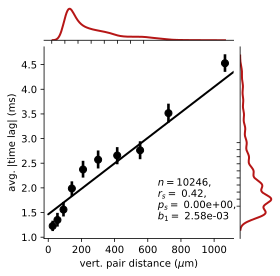

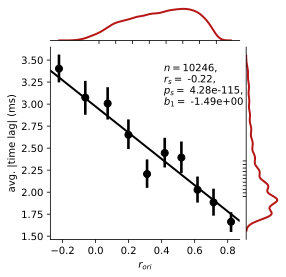

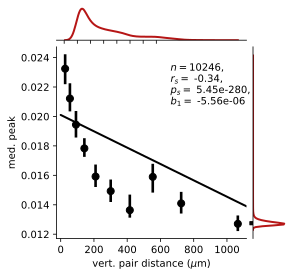

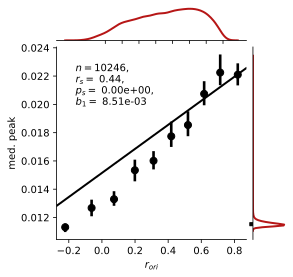

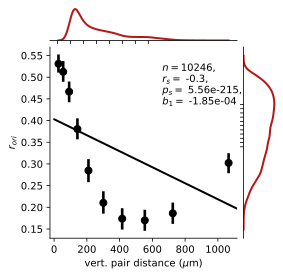

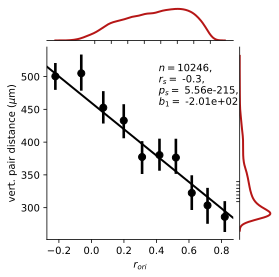

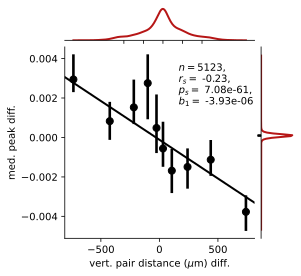

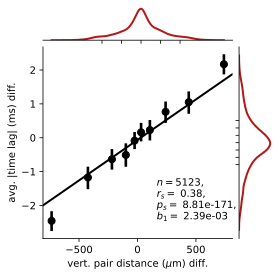

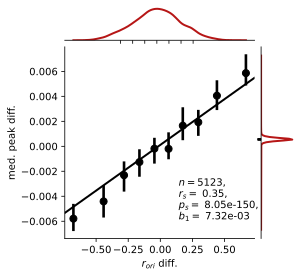

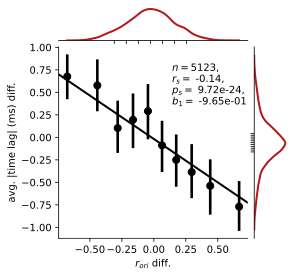

Linear Regression: avg. |time lag| (ms) = b_0 + b_1*vert. pair distance ($\mu$m) b_2*$r_{ori}$ + interaction 
regression p-values:
[0.00000000e+000 4.66530066e-198 5.31070261e-030 6.70870812e-001]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     805.0
Date:                Tue, 21 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:49:41   Log-Likelihood:                -22720.
No. Observations:               10246   AIC:                         4.545e+04
Df Residuals:                   10242   BIC:                         4.548e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
             

In [7]:
def plot_figure2(ccg_curr_half, config):
    data = pd.DataFrame({"med. peak": np.squeeze((ccg_curr_half['peaks'])),
                  "avg. |time lag| (ms)": np.squeeze(np.abs(ccg_curr_half['peak_lag'])),
                  "vert. pair distance ($\mu$m)": np.squeeze(ccg_curr_half['pair_distance']),
                  "$r_{ori}$": np.squeeze(ccg_curr_half['r_ori']), "put. cell type": np.squeeze(ccg_curr_half['pre_sc'])})

    y = "avg. |time lag| (ms)"
    x = "vert. pair distance ($\mu$m)"
    fig_path = config.figure_dir + 'fig2_lag_vs_pd.svg'
    plot_joint(data, x, y, fig_path, estimator=np.mean,xlim=(0,1100))

    y = "avg. |time lag| (ms)"
    x = "$r_{ori}$"
    fig_path = config.figure_dir + 'fig2_lag_vs_ori.svg'
    plot_joint(data, x, y, fig_path, text_ypos =.7,estimator=np.mean,xlim=(-.3,1))

    y = "med. peak"
    x = "vert. pair distance ($\mu$m)"
    fig_path = config.figure_dir + 'fig2_peak_vs_pd.svg'
    plot_joint(data, x, y, fig_path, text_ypos =.7, estimator=np.median,xlim=(0,1100), reg_outlier_y=True)

    y = "med. peak"
    x = "$r_{ori}$"
    fig_path = config.figure_dir + 'fig2_peak_vs_ori.svg'
    plot_joint(data, x, y, fig_path, text_xpos=.1,text_ypos =.7, estimator=np.median, reg_outlier_y=True)

    y = "$r_{ori}$"
    x = "vert. pair distance ($\mu$m)"
    fig_path = config.figure_dir + 'fig2_ori_vs_pd.svg'
    plot_joint(data, x, y, fig_path=fig_path, estimator=np.mean,text_ypos =.7,xlim=(0,1100))

    y = "vert. pair distance ($\mu$m)"
    x = "$r_{ori}$"
    fig_path = config.figure_dir + 'fig2_pd_vs_ori.svg'
    plot_joint(data, x, y, fig_path=fig_path, estimator=np.mean,text_ypos =.7,)

    dist_matched_data = construct_matched_data(data, 'vert. pair distance ($\mu$m)')
    r_ori_matched_data = construct_matched_data(data, '$r_{ori}$')

    xs = ["vert. pair distance ($\mu$m) diff.", "vert. pair distance ($\mu$m) diff.", "$r_{ori}$ diff.", "$r_{ori}$ diff."]
    ys = ["med. peak diff.", "avg. |time lag| (ms) diff.","med. peak diff.", "avg. |time lag| (ms) diff."]
    reg_outlier_y = [True, False, True, False]
    datasets = [r_ori_matched_data, r_ori_matched_data, dist_matched_data, dist_matched_data]
    fig_paths = ["fig2_ori_matched_peak","fig2_ori_matched_lag","fig2_dist_matched_peak","fig2_dist_matched_lag"]
    text_y_pos = [.7, .1, .1, .7]
    estimators = [np.median, np.mean, np.median, np.mean]

    for x, y, tdata, estimator, outlier, y_pos, f_path in zip(xs, ys, datasets, estimators, reg_outlier_y, text_y_pos, fig_paths):
        fig_path=config.figure_dir + f_path  + '.svg'
        plot_joint(tdata, x, y, fig_path=fig_path, estimator=estimator, text_ypos = y_pos, reg_outlier_y=outlier)
        
    run_linear_regression(data, "avg. |time lag| (ms)", "vert. pair distance ($\mu$m)", "$r_{ori}$")
    run_linear_regression(data, "med. peak", "vert. pair distance ($\mu$m)", "$r_{ori}$")

plot_figure2(ccg_curr_half, config)

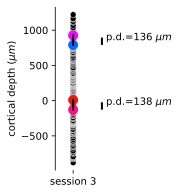

In [97]:
def plot_figure2_ex_tune(ccg_curr, ccg_all, ids, cols):
    sim1_col = cols[0]
    sim2_col = cols[1]
    dif1_col = cols[2]
    dif2_col = cols[3]
    sim_idx1 = ids[0]
    sim_idx2 = ids[1]
    dif_idx1 = ids[2]
    dif_idx2 = ids[3]

    ori_tuning = np.squeeze(ccg_curr['cluster'][0][0]['mean_ori_tune'])
    ses_3_tuning = ori_tuning
    ses_3_tuning = np.transpose(np.transpose(ses_3_tuning) - np.ndarray.min(ses_3_tuning, axis=1)) # subtract min, new min = 0
    one_over_range = 1/np.ptp(ses_3_tuning, axis=1)
    ses_3_tuning = ses_3_tuning*one_over_range[:,np.newaxis]     



    ori_tune_cell1 = ses_3_tuning[sim_idx1]
    ori_tune_cell2 = ses_3_tuning[sim_idx2]

    ori1_x, ori1_y = fit_von_mises(ori_tune_cell1)
    ori2_x, ori2_y = fit_von_mises(ori_tune_cell2)

    theta =  np.arange(0, 1+1/36, 1/36)*2*np.pi
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(1,2))
    ax.plot(theta, np.append(ori1_y, ori1_y[0]), linewidth=2, color=sim1_col)
    ax.plot(theta, np.append(ori2_y, ori2_y[0]), linewidth=2, color=sim2_col)
    ax.set_thetagrids([0,90,180,270])
    ax.set_rticks([])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.spines['polar'].set_visible(False)
    ax.set_aspect(2)
    plt.savefig(config.figure_dir + 'fig2_ex_tune_sim.svg', dpi=300, bbox_inches='tight')

    plt.show()

    ori_tune_cell1 = ses_3_tuning[dif_idx1]
    ori_tune_cell2 = ses_3_tuning[dif_idx2]

    ori1_x, ori1_y = fit_von_mises(ori_tune_cell1)
    ori2_x, ori2_y = fit_von_mises(ori_tune_cell2)

    theta =  np.arange(0, 1+1/36, 1/36)*2*np.pi
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(1,2))
    ax.plot(theta, np.append(ori1_y, ori1_y[0]), linewidth=2, color=dif1_col)
    ax.plot(theta, np.append(ori2_y, ori2_y[0]), linewidth=2, color=dif2_col)
    ax.set_thetagrids([0,90,180,270])
    ax.set_rticks([])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.spines['polar'].set_visible(False)
    ax.set_aspect(2)
    plt.savefig(config.figure_dir + 'fig2_ex_tune_diff.svg', dpi=300, bbox_inches='tight')

    plt.show()

    plt.figure(figsize=(2,2))

    df = pd.DataFrame({'firing rate cell 3': ses_3_tuning[sim_idx1], 'firing rate cell 4': ses_3_tuning[sim_idx2]})
    sns.scatterplot(data=df, x='firing rate cell 3', y='firing rate cell 4', color='k')
    plt.gca().text(.5, .4, '$r_{ori}$=' + str(round(float(ccg_all['r_ori'][np.logical_and(ccg_all['pre_id']==sim_idx1+1, ccg_all['post_id']==sim_idx2+1)]),2)), fontsize=10)

    plt.xlabel(plt.gca().get_xlabel(), color=sim1_col) #, bbox={'boxstyle': 'round', 'color':'k'}
    plt.ylabel(plt.gca().get_ylabel(), color=sim2_col) #,  bbox={'boxstyle': 'round', 'color':'k'}
    set_axis_defaults()
    plt.savefig(config.figure_dir + 'fig2_ex_signal_corr_sim.svg', dpi=300, bbox_inches='tight')

    plt.show()    

    plt.figure(figsize=(2,2))
    df = pd.DataFrame({'firing rate cell 1': ses_3_tuning[dif_idx1], 'firing rate cell 2': ses_3_tuning[dif_idx2]})    
    sns.scatterplot(data=df, x='firing rate cell 1', y='firing rate cell 2', color='k')
    plt.text(.5, .8, '$r_{ori}$=' + str(round(float(ccg_all['r_ori'][np.logical_and(ccg_all['pre_id']==dif_idx1+1, ccg_all['post_id']==dif_idx2+1)]),2)), fontsize=10)
    plt.tight_layout()

    plt.xlabel(plt.gca().get_xlabel(), color=dif1_col) #,  bbox={'boxstyle': 'round', 'color':'k'}
    plt.ylabel(plt.gca().get_ylabel(), color=dif2_col) #,  bbox={'boxstyle': 'round', 'color':'k'}
    set_axis_defaults()
    plt.savefig(config.figure_dir + 'fig2_ex_signal_corr_diff.svg', dpi=300, bbox_inches='tight')

    plt.show()    
    
def plot_figure2_network(ccg_curr_half, ids, cols):
    ccg_curr_half_t = ccg_curr_half.copy()
    session_idx = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_session'])
    depths = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celldepth'])
    med_peaks = []
    for idx in range(ccg_curr_half_t['cluster'][0][0]['Cluster_session'].size):
        med_peaks.append(np.median(ccg_curr_half_t['peaks'][np.logical_or(ccg_curr_half_t['pre_id'] == idx+1,ccg_curr_half_t['post_id'] == idx+1)]))

    cell_layer = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celllayer'])
    mean_peaks = np.array(med_peaks)
    ccg_curr = ccg_curr_half_t
    
    plt.figure(figsize=(4,6))
    np.random.default_rng(0)
    xrand = np.random.randn(*depths.shape)
    pre_x = np.ones_like(depths)+xrand/2
    cell_layer = np.array([(labels['cl'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in cell_layer])
    uq_ses = np.unique(session_idx)
    xdiv = 5
    xticks = []
    xticklabels = []
    
    nfive_quant = np.nanquantile(mean_peaks, .95)
    mean_peaks[mean_peaks>nfive_quant] = nfive_quant
    
    xs = np.array([])
    ys = np.array([])
    
    for i in range(uq_ses.size):
        ses_id = np.squeeze((session_idx == uq_ses[i]))
        xs = np.concatenate((xs, pre_x[ses_id] + xdiv*i))
        ys = np.concatenate((ys, depths[ses_id]))
    
    idx = np.argsort(depths)
    sns.scatterplot(x = xs, y = ys, hue=mean_peaks)
    #plt.plot(mean_peaks[idx]/np.nanmax(mean_peaks[idx]), depths[idx])
    plt.legend(frameon=False, loc='lower right')
    for i in range(uq_ses.size):
        ses_id = session_idx == uq_ses[i]
        xticks.append(xdiv*i+1)
        xticklabels.append('ses.' + str(i+1))

        if i == 2:
            for j in range(len(cols)):
                plt.scatter(pre_x[ids[j]] + xdiv*i, depths[ids[j]], color=cols[j],s=80)
            plt.plot([pre_x[ids[0]] + xdiv*i, pre_x[ids[1]] + xdiv*i],[depths[ids[0]],depths[ids[1]]], linewidth=2, color='k')
            plt.plot([pre_x[ids[2]] + xdiv*i, pre_x[ids[3]] + xdiv*i],[depths[ids[2]],depths[ids[3]]], linewidth=2, color='k')
            plt.plot([xdiv*i+4,xdiv*i+4],[depths[ids[0]],depths[ids[1]]], linestyle='--',linewidth=2, color='k')
            plt.plot([xdiv*i+4,xdiv*i+4],[depths[ids[2]],depths[ids[3]]], linestyle='--',linewidth=2, color='k')
            plt.text(xdiv*i+4.5,(depths[ids[2]]+depths[ids[3]])/2, 'p.d.=' + str(round(abs(depths[ids[2]]-depths[ids[3]])))+" $\mu m$")
            plt.text(xdiv*i+4.5,(depths[ids[0]]+depths[ids[1]])/2, 'p.d.=' + str(round(abs(depths[ids[0]]-depths[ids[1]])))+" $\mu m$")
    plt.gca().set_xlim(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]*1.4)
    ###plt.gca().legend(np.flip(np.append(labels['cl'], '_Hidden')), loc='upper right', frameon=False) 
    set_axis_defaults()
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_xticklabels(xticklabels)
    plt.gca().set_xticks(xticks)
    plt.ylabel("cortical depth ($\mu m$)")
    plt.savefig(config.figure_dir + 'fig2_network.svg', dpi=300, bbox_inches='tight')

    plt.show()

def plot_figure2_network_one_ses_no_peaks(ccg_curr_half, ids, cols):
    ccg_curr_half_t = ccg_curr_half.copy()
    session_idx = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_session'])
    depths = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celldepth'])
    med_peaks = []
    for idx in range(ccg_curr_half_t['cluster'][0][0]['Cluster_session'].size):
        med_peaks.append(np.median(ccg_curr_half_t['peaks'][np.logical_or(ccg_curr_half_t['pre_id'] == idx+1,ccg_curr_half_t['post_id'] == idx+1)]))

    cell_layer = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celllayer'])
    mean_peaks = np.array(med_peaks)
    ccg_curr = ccg_curr_half_t
    
    plt.figure(figsize=(4,6))
    np.random.default_rng(0)
    xrand = np.random.randn(*depths.shape)
    pre_x = np.ones_like(depths)+xrand/2
    cell_layer = np.array([(labels['cl'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in cell_layer])
    uq_ses = np.unique(session_idx)
    xdiv = 5
    xticks = []
    xticklabels = []
    
    nfive_quant = np.nanquantile(mean_peaks, .95)
    mean_peaks[mean_peaks>nfive_quant] = nfive_quant
    
    xs = np.array([])
    ys = np.array([])
    
    for i in range(uq_ses.size):
        if i == 2:
            ses_id = np.squeeze((session_idx == uq_ses[i]))
            xs = np.concatenate((xs, pre_x[ses_id]+xdiv*i))
            ys = np.concatenate((ys, depths[ses_id]))
    
    idx = np.argsort(depths)
    sns.scatterplot(x = xs, y = ys, color='k')
    #plt.plot(mean_peaks[idx]/np.nanmax(mean_peaks[idx]), depths[idx])
    #plt.legend(frameon=False, loc='lower right')
    for i in range(uq_ses.size):
        ses_id = session_idx == uq_ses[i]
        if i == 2:
            xticks.append(xdiv*i+1)
            xticklabels.append('session 3')

            if i == 2:
                for j in range(len(cols)):
                    plt.scatter(pre_x[ids[j]] + xdiv*i, depths[ids[j]], color=cols[j],s=80)
                plt.plot([pre_x[ids[0]] + xdiv*i, pre_x[ids[1]] + xdiv*i],[depths[ids[0]],depths[ids[1]]], linewidth=2, color='k')
                plt.plot([pre_x[ids[2]] + xdiv*i, pre_x[ids[3]] + xdiv*i],[depths[ids[2]],depths[ids[3]]], linewidth=2, color='k')
                plt.plot([xdiv*i+2.75,xdiv*i+2.75],[depths[ids[0]],depths[ids[1]]], linestyle='--',linewidth=2, color='k')
                plt.plot([xdiv*i+2.75,xdiv*i+2.75],[depths[ids[2]],depths[ids[3]]], linestyle='--',linewidth=2, color='k')
                plt.text(xdiv*i+3,(depths[ids[2]]+depths[ids[3]])/2, 'p.d.=' + str(round(abs(depths[ids[2]]-depths[ids[3]])))+" $\mu m$")
                plt.text(xdiv*i+3,(depths[ids[0]]+depths[ids[1]])/2, 'p.d.=' + str(round(abs(depths[ids[0]]-depths[ids[1]])))+" $\mu m$")
    plt.gca().set_xlim(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]*1.3)
    ###plt.gca().legend(np.flip(np.append(labels['cl'], '_Hidden')), loc='upper right', frameon=False) 
    set_axis_defaults()
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_xticklabels(xticklabels)
    plt.gca().set_xticks(xticks)
    plt.ylabel("cortical depth ($\mu m$)")
    plt.savefig(config.figure_dir + 'fig2_network.svg', dpi=300, bbox_inches='tight')

    plt.show()
    
def plot_figure3_network_one_ses_no_peaks(ccg_curr_half, ids, cols):
    ccg_curr_half_t = ccg_curr_half.copy()
    session_idx = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_session'])
    depths = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celldepth'])
    med_peaks = []
    for idx in range(ccg_curr_half_t['cluster'][0][0]['Cluster_session'].size):
        med_peaks.append(np.median(ccg_curr_half_t['peaks'][np.logical_or(ccg_curr_half_t['pre_id'] == idx+1,ccg_curr_half_t['post_id'] == idx+1)]))

    cell_layer = np.squeeze(ccg_curr_half_t['cluster'][0][0]['Cluster_celllayer'])
    mean_peaks = np.array(med_peaks)
    ccg_curr = ccg_curr_half_t
    
    plt.figure(figsize=(2,3))
    np.random.default_rng(0)
    xrand = 0 #np.random.randn(*depths.shape)
    pre_x = np.ones_like(depths)+xrand/2
    cell_layer = np.array([(labels['cl'][int(layer)-1] if ~np.isnan(layer) else np.nan) for layer in cell_layer])
    uq_ses = np.unique(session_idx)
    xdiv = 5
    xticks = []
    xticklabels = []
    
    nfive_quant = np.nanquantile(mean_peaks, .95)
    mean_peaks[mean_peaks>nfive_quant] = nfive_quant
    
    xs = np.array([])
    ys = np.array([])
    
    for i in range(uq_ses.size):
        if i == 2:
            ses_id = np.squeeze((session_idx == uq_ses[i]))
            xs = np.concatenate((xs, pre_x[ses_id]+xdiv*i))
            ys = np.concatenate((ys, depths[ses_id]))
    
    idx = np.argsort(depths)
    sns.scatterplot(x = xs, y = ys, color='k')
    #plt.plot(mean_peaks[idx]/np.nanmax(mean_peaks[idx]), depths[idx])
    #plt.legend(frameon=False, loc='lower right')
    for i in range(uq_ses.size):
        ses_id = session_idx == uq_ses[i]
        if i == 2:
            xticks.append(xdiv*i+1)
            xticklabels.append('session 3')

            if i == 2:
                for j in range(len(cols)):
                    plt.scatter(pre_x[ids[j]] + xdiv*i, depths[ids[j]], color=cols[j],s=80)
                plt.plot([pre_x[ids[0]] + xdiv*i, pre_x[ids[1]] + xdiv*i],[depths[ids[0]],depths[ids[1]]], linewidth=2, color='k')
                plt.plot([pre_x[ids[2]] + xdiv*i, pre_x[ids[3]] + xdiv*i],[depths[ids[2]],depths[ids[3]]], linewidth=2, color='k')
                plt.plot([xdiv*i+2.75,xdiv*i+2.75],[depths[ids[0]],depths[ids[1]]], linestyle='--',linewidth=2, color='k')
                plt.plot([xdiv*i+2.75,xdiv*i+2.75],[depths[ids[2]],depths[ids[3]]], linestyle='--',linewidth=2, color='k')
                plt.text(xdiv*i+3,(depths[ids[2]]+depths[ids[3]])/2, 'p.d.=' + str(round(abs(depths[ids[2]]-depths[ids[3]])))+" $\mu m$")
                plt.text(xdiv*i+3,(depths[ids[0]]+depths[ids[1]])/2, 'p.d.=' + str(round(abs(depths[ids[0]]-depths[ids[1]])))+" $\mu m$")
    plt.gca().set_xlim(plt.gca().get_xlim()[0]-1, plt.gca().get_xlim()[1]*1.3)
    ###plt.gca().legend(np.flip(np.append(labels['cl'], '_Hidden')), loc='upper right', frameon=False) 
    set_axis_defaults()
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_xticklabels(xticklabels)
    plt.gca().set_xticks(xticks)
    plt.ylabel("cortical depth ($\mu m$)")
    plt.savefig(config.figure_dir + 'fig3_network.svg', dpi=300, bbox_inches='tight')

    plt.show()


#plot_figure2_ex_tune(ccg_curr, ccg_all, ids, cols)
#plot_figure2_network(ccg_curr_half, ids, cols)
#plot_figure2_network_one_ses_no_peaks(ccg_curr_half, ids, cols)
init = 98

ids_match = [ids[0], ids[1], init, init + ids[1] - ids[0]-4];
cols_match = cols;
cols_match[2] = '#036bfc'
cols_match[3] = '#f803fc'
plot_figure3_network_one_ses_no_peaks(ccg_curr_half, ids_match, cols)

In [16]:
data = pd.DataFrame({"med. peak": np.squeeze((ccg_curr_half['peaks'])),
              "avg. |time lag| (ms)": np.squeeze(np.abs(ccg_curr_half['peak_lag'])),
              "vert. pair distance ($\mu$m)": np.squeeze(ccg_curr_half['pair_distance']),
              "$r_{ori}$": np.squeeze(ccg_curr_half['r_ori']), "put. cell type": np.squeeze(ccg_curr_half['pre_sc'])})

dist_matched_data = construct_matched_data(data, 'vert. pair distance ($\mu$m)')
r_ori_matched_data = construct_matched_data(data, '$r_{ori}$')

dist_matched_data.head(10)

,med. peak,avg. |time lag| (ms),vert. pair distance ($\mu$m),$r_{ori}$,put. cell type,med. peak diff.,avg. |time lag| (ms) diff.,vert. pair distance ($\mu$m) diff.,$r_{ori}$ diff.,put. cell type diff.
0,0.003135,-1,-0.003676,-0.478190,255,0.003135,-1,-0.003676,-0.478190,255
1,-0.046064,2,-0.004589,-0.558696,0,-0.046064,2,-0.004589,-0.558696,0
2,-0.000684,-2,-0.022910,0.058522,0,-0.000684,-2,-0.022910,0.058522,0
3,0.256460,-1,-0.002717,-0.162926,0,0.256460,-1,-0.002717,-0.162926,0
4,-0.080616,3,-0.048580,0.356655,1,-0.080616,3,-0.048580,0.356655,1
5,0.008116,0,-0.015464,0.155357,1,0.008116,0,-0.015464,0.155357,1
6,-0.003660,3,-0.017328,0.031423,0,-0.003660,3,-0.017328,0.031423,0
7,-0.013964,-1,-0.002534,0.547227,0,-0.013964,-1,-0.002534,0.547227,0
8,-0.025161,1,-0.035983,-0.193573,0,-0.025161,1,-0.035983,-0.193573,0
9,0.016953,-1,-0.004119,0.727159,0,0.016953,-1,-0.004119,0.727159,0


In [12]:
r_ori_matched_data.head(10)

,med. peak,avg. |time lag| (ms),vert. pair distance ($\mu$m),$r_{ori}$,put. cell type,med. peak diff.,avg. |time lag| (ms) diff.,vert. pair distance ($\mu$m) diff.,$r_{ori}$ diff.,put. cell type diff.
0,-0.000453,-2,264.402010,-0.035963,255,-0.000453,-2,264.402010,-0.035963,255
1,0.000424,-5,-697.418989,-0.014516,0,0.000424,-5,-697.418989,-0.014516,0
2,0.003090,1,-569.068593,-0.000103,1,0.003090,1,-569.068593,-0.000103,1
3,-0.005952,3,325.806520,-0.001352,1,-0.005952,3,325.806520,-0.001352,1
4,-0.000145,-3,-94.781449,-0.004009,1,-0.000145,-3,-94.781449,-0.004009,1
5,-0.002525,8,-967.302904,-0.002477,255,-0.002525,8,-967.302904,-0.002477,255
6,0.000794,-9,-674.714834,-0.000810,1,0.000794,-9,-674.714834,-0.000810,1
7,-0.002980,4,381.113617,-0.003451,0,-0.002980,4,381.113617,-0.003451,0
8,0.003994,-3,-501.478183,-0.000747,0,0.003994,-3,-501.478183,-0.000747,0
9,0.000939,-2,-209.657665,-0.004514,0,0.000939,-2,-209.657665,-0.004514,0
